# **6. Mastering Backpropagation**

In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# **Let's prepare the dataset**
---

We use digits classification cases

In [2]:
from sklearn.datasets import load_digits

In [3]:
# import dataset
X, y = load_digits(return_X_y=True)

# Validate
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1797, 64)
y shape: (1797,)


Next, we split the data into train, valid, and test set

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Split train & (valid and test) --> 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# Split valid & test --> 50:50
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test,
    y_test,
    stratify=y_test,
    test_size=0.5,
    random_state=42
)

# Validate
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X valid shape:', X_valid.shape)
print('y valid shape:', y_valid.shape)
print('X test shape :', X_test.shape)
print('y test shape :', y_test.shape)

X train shape: (1437, 64)
y train shape: (1437,)
X valid shape: (180, 64)
y valid shape: (180,)
X test shape : (180, 64)
y test shape : (180,)


In [6]:
# Convert to torch tensor
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)
X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)

# **Create a Comparison Function**
---

Next, we create a utility function to compare manual gradients to PyTorch gradients

In [7]:
# This code is adapted from NN zero to hero, Andrej Karpathy
def compare_grad(element, manual_grad, torch_node):
    """comparing manual gradients to PyTorch gradients"""
    # Extract gradients
    torch_grad = torch_node.grad

    # Exact comparison
    exact = torch.all(manual_grad == torch_grad).item()

    # Approximate comparison
    apprx = torch.allclose(manual_grad, torch_grad)

    # Calculate maximum different between manual and torch gradients
    max_diff = (
        (manual_grad-torch_grad)    # calculate the difference
        .abs()                      # then take the absolute value
        .max()                      # and find the maximum value of it
        .item()
    )

    # Print
    print(f'{element:15s} | exact: {str(exact):5s} | approximate: {str(apprx):5s} | max diff.: {max_diff}')


# **Create the Neural Network using PyTorch**
---

- We create a neural network to classify the digits.
- The architectures are
  - Have 64 input dimensions
  - Have 2 layers (1 hidden layer and 1 output layer)
  - The output layer has 10 neurons (1 neuron for each digits)

In [8]:
# Defining the size
n_in = 64
n_hidden = 15
n_out = 10

In [9]:
# Create the Neural Network
g = torch.Generator().manual_seed(42)

# Layer 1 (The hidden layer)
W1 = torch.randn((n_in, n_hidden),  generator=g) * (5/3) / (n_in**0.5)
b1 = torch.randn(n_hidden,          generator=g) * 0.1

# Layer 2 (The output layer)
W2 = torch.randn((n_hidden, n_out), generator=g) * 0.1
b2 = torch.randn(n_out,             generator=g) * 0.1

# Batch normalization parameters
bn_gain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0
bn_bias = torch.randn((1, n_hidden), generator=g) * 0.1

# Get the parameters
parameters = [W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(param.nelement() for param in parameters))

# Activate the grad
for param in parameters:
    param.requires_grad = True


1165


Next, we create a single forward pass that we want to calculate its gradients manually. Yeay!

In [10]:
# Create a batch learning
batch_size = 16
n = batch_size

# Construct a minibatch
mini_ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
X_batch, y_batch = X_train[mini_ix], y_train[mini_ix]

# Validate
print('X_batch shape:', X_batch.shape)
print('y_batch shape:', y_batch.shape)

X_batch shape: torch.Size([16, 64])
y_batch shape: torch.Size([16])


In [11]:
# Perform a forward pass

# The hidden layer
h_pre_bn = X_batch @ W1 + b1

# Batch normalization layer
bn_mean_i = (1./n) * h_pre_bn.sum(0, keepdim=True)
bn_diff = h_pre_bn - bn_mean_i
bn_diff2 = bn_diff**2
bn_var = (1./(n-1)) * bn_diff2.sum(0, keepdim=True)
bn_var_inv = (bn_var + 1e-5)**(-0.5)
bn_raw = bn_diff * bn_var_inv
h_pre_act = bn_gain * bn_raw + bn_bias

# Non-linearity
h = torch.tanh(h_pre_act)

# The output layer
logits = h @ W2 + b2

# Calculate loss
counts = logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
log_probs = probs.log()
loss = -log_probs[range(n), y_batch].mean()

# Do the backward pass with PyTorch
for p in parameters:
    p.grad = None

for p in [log_probs, probs, counts_sum_inv, counts_sum, counts,
          logits, h, h_pre_act,
          bn_raw, bn_var_inv, bn_var, bn_diff2, bn_diff, bn_mean_i,
          h_pre_bn]:
    p.retain_grad()

loss.backward()
loss

tensor(2.2752, grad_fn=<NegBackward0>)

# **Task 1: Backprop the whole things manually**
---

Similar to the pre-class video, perform backpropagation through the whole things manually and compare the gradients to the PyTorch gradients

In [13]:
dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(n), y_batch] = -1./n
dprobs = (1./probs) * dlog_probs
dcounts_sum_inv = (counts*dprobs).sum(1, keepdim=True)
dcounts_sum = (-1) * (counts_sum**(-2)) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dlogits = counts * dcounts
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dh_pre_act = (1. - h**2) * dh
dbn_bias = dh_pre_act.sum(0, keepdim=True)
dbn_gain = (bn_raw * dh_pre_act).sum(0, keepdim=True)
dbn_raw = bn_gain * dh_pre_act
dbn_var_inv = (bn_diff*dbn_raw).sum(0, keepdim=True)
dbn_var = (-0.5)*((bn_var + 1e-5)**(-1.5)) * dbn_var_inv
dbn_diff2 = (1./(n-1)) * torch.ones_like(bn_diff2) * dbn_var
dbn_diff = 2. * bn_diff * dbn_diff2
dbn_diff += bn_var_inv * dbn_raw
dbn_mean_i = -1. * dbn_diff.sum(0, keepdim=True)
dh_pre_bn = dbn_diff.clone()
dh_pre_bn += (1./n) * torch.ones_like(h_pre_bn) * dbn_mean_i
dW1 = X_batch.T @ dh_pre_bn
db1 = dh_pre_bn.sum(0)

# Compare the gradients
compare_grad('log_probs', dlog_probs, log_probs)
compare_grad('probs', dprobs, probs)
compare_grad('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare_grad('counts_sum', dcounts_sum, counts_sum)
compare_grad('counts', dcounts, counts)
compare_grad('logits', dlogits, logits)
compare_grad('h', dh, h)
compare_grad('W2', dW2, W2)
compare_grad('b2', db2, b2)
compare_grad('h_pre_act', dh_pre_act, h_pre_act)
compare_grad('bn_bias', dbn_bias, bn_bias)
compare_grad('bn_gain', dbn_gain, bn_gain)
compare_grad('bn_raw', dbn_raw, bn_raw)
compare_grad('bn_var_inv', dbn_var_inv, bn_var_inv)
compare_grad('bn_var', dbn_var, bn_var)
compare_grad('bn_diff2', dbn_diff2, bn_diff2)
compare_grad('bn_diff', dbn_diff, bn_diff)
compare_grad('bn_mean_i', dbn_mean_i, bn_mean_i)
compare_grad('h_pre_bn', dh_pre_bn, h_pre_bn)
compare_grad('W1', dW1, W1)
compare_grad('b1', db1, b1)

log_probs       | exact: True  | approximate: True  | max diff.: 0.0
probs           | exact: True  | approximate: True  | max diff.: 0.0
counts_sum_inv  | exact: True  | approximate: True  | max diff.: 0.0
counts_sum      | exact: True  | approximate: True  | max diff.: 0.0
counts          | exact: True  | approximate: True  | max diff.: 0.0
logits          | exact: True  | approximate: True  | max diff.: 0.0
h               | exact: True  | approximate: True  | max diff.: 0.0
W2              | exact: True  | approximate: True  | max diff.: 0.0
b2              | exact: True  | approximate: True  | max diff.: 0.0
h_pre_act       | exact: False | approximate: True  | max diff.: 9.313225746154785e-10
bn_bias         | exact: False | approximate: True  | max diff.: 3.725290298461914e-09
bn_gain         | exact: False | approximate: True  | max diff.: 1.862645149230957e-09
bn_raw          | exact: False | approximate: True  | max diff.: 9.313225746154785e-10
bn_var_inv      | exact: False 

# **Task 2: Backprop the cross entropy loss**
---

This is too long

```python
# Calculate loss
counts = logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
log_probs = probs.log()
loss = -log_probs[range(n), y_batch].mean()
```

We can simplify this as

In [14]:
# Simplify
loss_simple = F.cross_entropy(input=logits, target=y_batch)

# Print
print(loss_simple.item())
print(f'Difference to before: {(loss_simple-loss).item()}')

2.2752017974853516
Difference to before: 2.384185791015625e-07


Then, find the gradients of loss w.r.t the logits manually

In [15]:
# Softmax function
dlogits_simple = F.softmax(logits, 1)
dlogits_simple[range(n), y_batch] -= 1
dlogits_simple /= n

# Compare the gradients
compare_grad('logits', dlogits_simple, logits)

logits          | exact: False | approximate: True  | max diff.: 7.450580596923828e-09


# **Task 3: Train with manual backpropagation**
---

First, reinitialize the weights

In [16]:
# Create the Neural Network
g = torch.Generator().manual_seed(42)

# Layer 1 (The hidden layer)
W1 = torch.randn((n_in, n_hidden),  generator=g) * (5/3) / (n_in**0.5)
b1 = torch.randn(n_hidden,          generator=g) * 0.1

# Layer 2 (The output layer)
W2 = torch.randn((n_hidden, n_out), generator=g) * 0.1
b2 = torch.randn(n_out,             generator=g) * 0.1

# Batch normalization parameters
bn_gain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0
bn_bias = torch.randn((1, n_hidden), generator=g) * 0.1

# Get the parameters
parameters = [W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(param.nelement() for param in parameters))

# Activate the grad
for param in parameters:
    param.requires_grad = True


1165


Then let's train

In [17]:
max_steps = 100_000
batch_size = 16
n = batch_size
losses = []

# We will calculate the grad manually
with torch.no_grad():

    # Start optimizing
    for i in range(max_steps):
        # Construct a minibatch
        mini_ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        X_batch, y_batch = X_train[mini_ix], y_train[mini_ix]

        # Perform the forward pass
        h_pre_bn = X_batch @ W1 + b1
        bn_mean_i = (1./n) * h_pre_bn.sum(0, keepdim=True)
        bn_diff = h_pre_bn - bn_mean_i
        bn_diff2 = bn_diff**2
        bn_var = (1./(n-1)) * bn_diff2.sum(0, keepdim=True)
        bn_var_inv = (bn_var + 1e-5)**(-0.5)
        bn_raw = bn_diff * bn_var_inv
        h_pre_act = bn_gain * bn_raw + bn_bias
        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2

        # Calculate loss
        loss = F.cross_entropy(input=logits, target=y_batch)

        # Let's do the backward pass
        for p in parameters:
            p.grad = None

        # Let's manually calculate the gradients
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), y_batch] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dh_pre_act = (1. - h**2) * dh
        dbn_bias = dh_pre_act.sum(0, keepdim=True)
        dbn_gain = (bn_raw * dh_pre_act).sum(0, keepdim=True)
        dbn_raw = bn_gain * dh_pre_act
        dbn_var_inv = (bn_diff*dbn_raw).sum(0, keepdim=True)
        dbn_var = (-0.5)*((bn_var + 1e-5)**(-1.5)) * dbn_var_inv
        dbn_diff2 = (1./(n-1)) * torch.ones_like(bn_diff2) * dbn_var
        dbn_diff = 2. * bn_diff * dbn_diff2
        dbn_diff += bn_var_inv * dbn_raw
        dbn_mean_i = -1. * dbn_diff.sum(0, keepdim=True)
        dh_pre_bn = dbn_diff.clone()
        dh_pre_bn += (1./n) * torch.ones_like(h_pre_bn) * dbn_mean_i
        dW1 = X_batch.T @ dh_pre_bn
        db1 = dh_pre_bn.sum(0)
        grads = [dW1, db1, dW2, db2, dbn_gain, dbn_bias]  # store the grads of our model parameters

        # Update the model parameters
        lr = 0.1 if i < 50_000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad

        # Track
        if i%10000 == 0:
            print(f'{i:8d}/{max_steps:8d}: {loss.item():.4f}')
        losses.append(loss.log().item())


       0/  100000: 2.2752
   10000/  100000: 0.0575
   20000/  100000: 0.0262
   30000/  100000: 0.0202
   40000/  100000: 0.0043
   50000/  100000: 0.0404
   60000/  100000: 0.3940
   70000/  100000: 0.0029
   80000/  100000: 0.0019
   90000/  100000: 0.0038


In [18]:
# Calibrate the batch normalization layer
with torch.no_grad():
    # pass the training set through
    h_pre_bn = X_train @ W1 + b1
    bn_mean_i = (1./n) * h_pre_bn.sum(0, keepdim=True)
    bn_diff = h_pre_bn - bn_mean_i
    bn_diff2 = bn_diff**2
    bn_var = (1./(n-1)) * bn_diff2.sum(0, keepdim=True)
    bn_var_inv = (bn_var + 1e-5)**(-0.5)
    bn_raw = bn_diff * bn_var_inv
    h_pre_act = bn_gain * bn_raw + bn_bias

    # measure the mean/std over the entire training set
    bn_mean = h_pre_act.mean(0, keepdim=True)
    bn_var = h_pre_act.var(0, keepdim=True, unbiased=True)

Lets evaluate

In [19]:
@torch.no_grad()
def check_loss(split):
    X, y = {
    'train': (X_train, y_train),
    'valid': (X_valid, y_valid),
    'test': (X_test, y_test),
    }[split]

    # Perform a forward pass
    h_pre_bn = X @ W1 + b1
    bn_diff = h_pre_bn - bn_mean
    bn_var_inv = (bn_var + 1e-5)**(-0.5)
    bn_raw = bn_diff * bn_var_inv
    h_pre_act = bn_gain * bn_raw + bn_bias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())

check_loss('train')
check_loss('valid')

train 0.6982054710388184
valid 0.9543957114219666


Let's predict

In [20]:
@torch.no_grad()
def predict(split):
    X, y = {
    'train': (X_train, y_train),
    'valid': (X_valid, y_valid),
    'test': (X_test, y_test),
    }[split]

    # Perform a forward pass
    h_pre_bn = X @ W1 + b1
    bn_diff = h_pre_bn - bn_mean
    bn_var_inv = (bn_var + 1e-5)**(-0.5)
    bn_raw = bn_diff * bn_var_inv
    h_pre_act = bn_gain * bn_raw + bn_bias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    y_pred = probs.max(1).indices
    y_pred_proba = probs.max(1).values

    return y_pred, y_pred_proba

y_test_pred, y_test_pred_proba = predict('test')

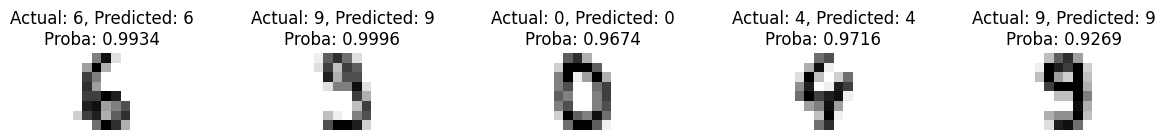

In [21]:
# plot
ix = torch.randint(0, X_test.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred, proba in zip(axes, X_test[ix], y_test[ix], y_test_pred[ix], y_test_pred_proba[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}\nProba: {proba:.4f}', fontsize=12)